In [23]:
import torch.nn as nn
import math
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
from collections import OrderedDict
from torch.utils import model_zoo
from PIL import Image
import json
import requests
import torchvision.models as models
import numpy as np
import foolbox
from foolbox.attacks import LBFGSAttack
from foolbox.criteria import TargetClassProbability
import matplotlib.pyplot as plt
import os 

In [9]:
print(torch.__version__)

1.0.1.post2


In [10]:
model_urls = {
            'bagnet8': 'https://bitbucket.org/wielandbrendel/bag-of-feature-pretrained-models/raw/249e8fa82c0913623a807d9d35eeab9da7dcc2a8/bagnet8-34f4ccd2.pth.tar',
            'bagnet16': 'https://bitbucket.org/wielandbrendel/bag-of-feature-pretrained-models/raw/249e8fa82c0913623a807d9d35eeab9da7dcc2a8/bagnet16-105524de.pth.tar',
            'bagnet32': 'https://bitbucket.org/wielandbrendel/bag-of-feature-pretrained-models/raw/249e8fa82c0913623a807d9d35eeab9da7dcc2a8/bagnet32-2ddd53ed.pth.tar',
            }

LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'


response = requests.get(LABELS_URL)  
labels = {str(key): value for key, value in response.json().items()}

# load the image transformer
centre_crop = trn.Compose([
        trn.Resize((256,256)),
        trn.CenterCrop(224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, kernel_size=1):
        super(Bottleneck, self).__init__()
        #print('Creating bottleneck with kernel size {} and stride {} with padding {}'.format(kernel_size, stride, (kernel_size - 1) // 2))
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size, stride=stride,
                               padding=0, bias=False) # changed padding from (kernel_size - 1) // 2
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x, **kwargs):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)
        
        if residual.size(-1) != out.size(-1):
            diff = residual.size(-1) - out.size(-1)
            residual = residual[:,:,:-diff,:-diff]
        
        out += residual
        out = self.relu(out)

        return out


class BagNet(nn.Module):

    def __init__(self, block, layers, strides=[1, 2, 2, 2], kernel3=[0, 0, 0, 0], num_classes=1000, avg_pool=True):
        self.inplanes = 64
        super(BagNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=1, stride=1, padding=0,
                               bias=False)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64, momentum=0.001)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=strides[0], kernel3=kernel3[0], prefix='layer1')
        self.layer2 = self._make_layer(block, 128, layers[1], stride=strides[1], kernel3=kernel3[1], prefix='layer2')
        self.layer3 = self._make_layer(block, 256, layers[2], stride=strides[2], kernel3=kernel3[2], prefix='layer3')
        self.layer4 = self._make_layer(block, 512, layers[3], stride=strides[3], kernel3=kernel3[3], prefix='layer4')
        self.avgpool = nn.AvgPool2d(1, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.avg_pool = avg_pool
        self.block = block

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, kernel3=0, prefix=''):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        kernel = 1 if kernel3 == 0 else 3
        layers.append(block(self.inplanes, planes, stride, downsample, kernel_size=kernel))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            kernel = 1 if kernel3 <= i else 3
            layers.append(block(self.inplanes, planes, kernel_size=kernel))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.avg_pool:
            x = nn.AvgPool2d(x.size()[2], stride=1)(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)
        else:
            x = x.permute(0,2,3,1)
            x = self.fc(x)

        return x

In [11]:
def bagnet8(pretrained=False, strides=[2, 2, 2, 1], **kwargs):
    """Constructs a Bagnet-8 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = BagNet(Bottleneck, [3, 4, 6, 3], strides=strides, kernel3=[1,1,0,0], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['bagnet8'], map_location='cpu'))
    return model

In [25]:
# instantiate the model
resnet18 = bagnet8(pretrained=True)  # for CPU, remove cuda()
mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
model = foolbox.models.PyTorchModel(resnet18, bounds=(0, 1), num_classes=1000, preprocessing=(mean, std))

# get source image and label
image, label = foolbox.utils.imagenet_example(data_format='channels_first')
image = image / 255.  # because our model expects values in [0, 1]

print('label', label)
print('predicted class', np.argmax(model.predictions(image)))

# apply attack on source image
attack = foolbox.attacks.FGSM(model)
adversarial = attack(image, label)

print('adversarial class', np.argmax(model.predictions(adversarial)))

/Users/mk365/anaconda3/envs/bagnets/lib/python3.7/site-packages/foolbox/models/pytorch.py:62: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  'The PyTorch model is in training mode and therefore might'


label 282
predicted class 151


/Users/mk365/anaconda3/envs/bagnets/lib/python3.7/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'


adversarial class 151


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


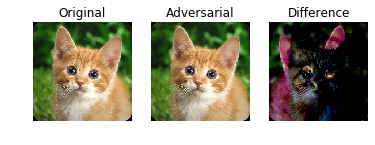

In [30]:
plt.figure()

plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(np.transpose(image, (1, 2, 0))) 
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Adversarial')
plt.imshow(np.transpose(adversarial, (1, 2, 0)))  # ::-1 to convert BGR to RGB
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Difference')
difference = adversarial[:, :, ::-1] - image
plt.imshow(np.transpose(difference, (1, 2, 0)))
plt.axis('off')

plt.show()